# B21AI056 MLOps Quantization ML Assignment
MLFlow Report Available at https://dagshub.com/Niticodersh/Mlops_assignment.mlflow/#/experiments/2/runs/436d626a18a1453589f781f1b30fbc77

## Environment Setup

In [ ]:
%%capture
!pip install mlflow
!pip install dagshub

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import time
import mlflow
import mlflow.pytorch
import dagshub

In [ ]:
dagshub.init(repo_owner='Niticodersh', repo_name='Mlops_assignment', mlflow=True)
mlflow.set_experiment("Quantized Machine Learning")

remote_server_uri = 'https://dagshub.com/Niticodersh/Mlops_assignment.mlflow'
mlflow.set_registry_uri(remote_server_uri)

Initialized MLflow to track repo "Niticodersh/Mlops_assignment"

Repository Niticodersh/Mlops_assignment initialized!

In [ ]:
mlflow.start_run()

<ActiveRun: >

## Data Loading

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Building

In [ ]:
class LogisticRegressionModel(nn.Module):
  def __init__(self, input_dim, num_classes):
    super(LogisticRegressionModel, self).__init__()
    self.linear = nn.Linear(input_dim, num_classes)

  def forward(self, x):
    # return torch.softmax(self.linear(x), dim=1)
    return self.linear(x)

#Model Initialization
input_size = X.shape[1]
print(f'Input size = {input_size}')
num_classes = len(np.unique(y_train))
print(f'Number of classes = {num_classes}')
model = LogisticRegressionModel(input_size, num_classes)
print(f'Model Architecture : \n {model}')

Input size = 64
Number of classes = 10
Model Architecture : 
 LogisticRegressionModel(
  (linear): Linear(in_features=64, out_features=10, bias=True)
)


## Data Transformation

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(len(X_train_tensor))
print(len(X_test_tensor))

1437
360


In [ ]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train the Logistic Regression Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
plot_train_losses = []
plot_test_losses = []
best_test_loss = float('inf')
epochs = 100

# Log hyperparameters
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)
mlflow.log_param("learning_rate", 0.01)
mlflow.log_param("optimizer", "SGD")
mlflow.log_param("loss_function", "CrossEntropyLoss")
print()

In [ ]:
for epoch in range(epochs):
  model.train()
  running_train_loss = 0.0
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_train_loss += loss.item()

  train_loss = running_train_loss/len(train_loader)
  plot_train_losses.append(train_loss)

  model.eval()
  with torch.no_grad():
    running_test_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(test_loader):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_test_loss += loss.item()

  test_loss = running_test_loss/len(test_loader)
  plot_test_losses.append(test_loss)

  # Log losses for each epoch
  mlflow.log_metric("train_loss", train_loss, step=epoch)
  mlflow.log_metric("test_loss", test_loss, step=epoch)

  if test_loss < best_test_loss:
    best_test_loss = test_loss
    torch.save(model.state_dict(), 'best_model.pth')

  if epoch%10 == 0:
    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [0/100], Train Loss: 2.2017, Test Loss: 1.9907
Epoch [10/100], Train Loss: 0.6952, Test Loss: 0.6927
Epoch [20/100], Train Loss: 0.4590, Test Loss: 0.4644
Epoch [30/100], Train Loss: 0.3592, Test Loss: 0.3683
Epoch [40/100], Train Loss: 0.3030, Test Loss: 0.3147
Epoch [50/100], Train Loss: 0.2700, Test Loss: 0.2802
Epoch [60/100], Train Loss: 0.2421, Test Loss: 0.2558
Epoch [70/100], Train Loss: 0.2259, Test Loss: 0.2376
Epoch [80/100], Train Loss: 0.2070, Test Loss: 0.2232
Epoch [90/100], Train Loss: 0.1935, Test Loss: 0.2117


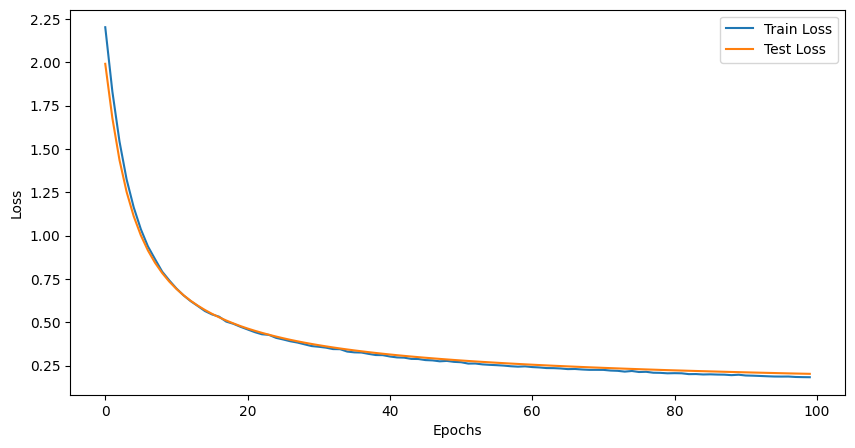

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(plot_train_losses, label='Train Loss')
plt.plot(plot_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
mlflow.log_artifact('loss_plot.png')
plt.show()

## Load the best model

In [ ]:
model = LogisticRegressionModel(input_size, num_classes)
model.load_state_dict(torch.load('best_model.pth'))
mlflow.pytorch.log_model(model, "best_model")
model.eval()

<ipython-input-44-5125bb40a550>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
2024/10/15 18:21:47 WARNING mlflow.utils

LogisticRegressionModel(
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

## Model Inferencing

In [ ]:
def test_model(model, test_loader):
  start_time = time.time()
  with torch.no_grad():
    test_outputs = torch.softmax(model(X_test_tensor), dim=1)
    _, predicted = torch.max(test_outputs, dim=1)
    accuracy = (predicted == y_test_tensor).sum().item()/len(y_test_tensor) * 100
  end_time = time.time()
  inference_time = end_time - start_time
  print(f"Inference Time: {inference_time:.4f} seconds")
  print(f"Accuracy: {accuracy:.4f}%")

  return inference_time, accuracy

In [ ]:
def model_size(model, quantized=False):
  total_size = 0
  total_params = 0
  if quantized==False:
     for layer in model.children():
        if hasattr(layer, 'weight') and layer.weight is not None:
          weight_tensor = layer.weight.data
          weight_size = len(weight_tensor.flatten())
          total_params+= weight_size
          if weight_tensor.dtype == torch.float32:
            total_size+= weight_size * 4
          elif weight_tensor.dtype == torch.int8:
            total_size+= weight_size * 1
          elif weight_tensor.dtype == torch.int32:
            total_size+= weight_size * 4
          elif weight_tensor.dtype == torch.int64:
            total_size+= weight_size * 8
          elif weight_tensor.dtype == torch.float64:
            total_size+= weight_size * 8


        if hasattr(layer, 'bias') and layer.bias is not None:
          bias_tensor = layer.bias.data
          bias_size = len(bias_tensor.flatten())
          total_params+= bias_size
          if bias_tensor.dtype == torch.float32:
            total_size+= bias_size * 4
          elif bias_tensor.dtype == torch.int8:
            total_size+= bias_size * 1
          elif bias_tensor.dtype == torch.int32:
            total_size+= bias_size * 4
          elif bias_tensor.dtype == torch.int64:
            total_size+= bias_size * 8
          elif bias_tensor.dtype == torch.float64:
            total_size+= bias_size * 8

  else:
    for layer in model.children():
      if hasattr(layer, 'weight') and layer.weight is not None:
        weight_tensor = layer.weight()
        weight_size = len(weight_tensor.flatten())
        total_params+= weight_size

        if weight_tensor.dtype == torch.qint8:
          total_size+= weight_size * 1
        elif weight_tensor.dtype == torch.qint32:
          total_size+= weight_size * 4


      if hasattr(layer, 'bias') and layer.bias is not None:
        bias_tensor = layer.bias()
        bias_size = len(bias_tensor.flatten())
        total_params+= bias_size
        if bias_tensor.dtype == torch.qint8:
          total_size+= bias_size * 1
        elif bias_tensor.dtype == torch.qint32:
          total_size+= bias_size * 4
        elif bias_tensor.dtype == torch.float32:
          total_size+= bias_size * 4
        elif bias_tensor.dtype == torch.int8:
          total_size+= bias_size * 1
        elif bias_tensor.dtype == torch.int32:
          total_size+= bias_size * 4
        elif bias_tensor.dtype == torch.int64:
          total_size+= bias_size * 8
        elif bias_tensor.dtype == torch.float64:
          total_size+= bias_size * 8

  print(f"Number of model parameters: {total_params}")

  print(f"Model size: {total_size} Bytes")

  return total_params, total_size

In [ ]:
inf_time1, acc1 = test_model(model, test_loader)
mlflow.log_metric("inference_time_original", inf_time1)
mlflow.log_metric("accuracy_original", acc1)
params1, size1 = model_size(model)
mlflow.log_metric("original_model_params", params1)
mlflow.log_metric("original_model_size_bytes", size1)

Inference Time: 0.0019 seconds
Accuracy: 95.8333%
Number of model parameters: 650
Model size: 2600 Bytes


## Quantize Model

In [ ]:
def dynamic_quantize_model(model):
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

# Apply dynamic quantization
quantized_model1 = dynamic_quantize_model(model)

# Save and log the quantized model
torch.save(quantized_model1.state_dict(), 'dynamic_quantized_model.pth')
mlflow.pytorch.log_model(quantized_model1, "dynamic_quantized_model")


2024/10/15 18:21:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 18:22:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 18:22:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
def static_quantize_model(model, calibration_data):
    # Prepare the model for static quantization
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    # Calibrate the model with sample input data
    model(calibration_data)

    # Convert the model to quantized form
    quantized_model = torch.quantization.convert(model, inplace=False)
    return quantized_model

# Assuming you have calibration_data
quantized_model2 = static_quantize_model(model, calibration_data = X_train_tensor[:100])

# Save and log the quantized model
torch.save(quantized_model2.state_dict(), 'static_quantized_model.pth')
mlflow.pytorch.log_model(quantized_model2, "static_quantized_model")


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
2024/10/15 18:22:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 18:22:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip

In [ ]:
def qat_quantize_model(model, num_epochs, data_loader, optimizer, loss_fn):
    model.train()
    # Prepare the model for quantization-aware training
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(model, inplace=True)

    # Train the model with QAT (example training loop)
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    # Convert to quantized model after QAT
    quantized_model = torch.quantization.convert(model.eval(), inplace=False)
    return quantized_model

# Assuming you have num_epochs, data_loader, optimizer, and loss_fn defined
quantized_model3 = qat_quantize_model(model, epochs, train_loader, optimizer, criterion)

# Save and log the quantized model
torch.save(quantized_model3.state_dict(), 'qat_quantized_model.pth')
mlflow.pytorch.log_model(quantized_model3, "qat_quantized_model")


2024/10/15 18:22:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 18:22:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 18:22:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Layers Type Checking and Validating Quantization Process

In [ ]:
qunatized_value = quantized_model1.linear.weight().int_repr().flatten()[0].item()
scale_factor = quantized_model1.linear.weight().q_scale()
zero_point = quantized_model1.linear.weight().q_zero_point()
original_value = quantized_model1.linear.weight().flatten()[0].item()
print("Quantized value type:", quantized_model1.linear.weight().dtype)
print(f'Quantized Value : {qunatized_value}')
print(f'Scale Factor : {scale_factor}')
print(f'Zero Point : {zero_point}')
print(f'Original Value : {original_value}')

Quantized value type: torch.qint8
Quantized Value : 26
Scale Factor : 0.004505508113652468
Zero Point : 0
Original Value : 0.11714321374893188


In [ ]:
# Manual Checking
(original_value - zero_point)/scale_factor

26.00000062012267

## Quantized Model Inferencing

In [ ]:
# For quantized_model2
inf_time2, acc2 = test_model(quantized_model1, test_loader)
mlflow.log_metric("inference_time_quantized_model2", inf_time2)
mlflow.log_metric("accuracy_quantized_model2", acc2)
params2, size2 = model_size(quantized_model1, quantized=True)
mlflow.log_metric("quantized_model2_params", params2)
mlflow.log_metric("quantized_model2_size_bytes", size2)

# # For quantized_model3
# inf_time3, acc3 = test_model(quantized_model2, test_loader)
# mlflow.log_metric("inference_time_quantized_model3", inf_time3)
# mlflow.log_metric("accuracy_quantized_model3", acc3)
# params3, size3 = model_size(quantized_model2, quantized=True)
# mlflow.log_metric("quantized_model3_params", params3)
# mlflow.log_metric("quantized_model3_size_bytes", size3)

# For quantized_model4
inf_time4, acc4 = test_model(quantized_model3, test_loader)
mlflow.log_metric("inference_time_quantized_model4", inf_time4)
mlflow.log_metric("accuracy_quantized_model4", acc4)
params4, size4 = model_size(quantized_model3, quantized=True)
mlflow.log_metric("quantized_model4_params", params4)
mlflow.log_metric("quantized_model4_size_bytes", size4)

Inference Time: 0.0060 seconds
Accuracy: 95.8333%
Number of model parameters: 650
Model size: 680 Bytes


NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at ../aten/src/ATen/native/quantized/cpu/qlinear.cpp:1317 [kernel]
QuantizedCUDA: registered at ../aten/src/ATen/native/quantized/cudnn/Linear.cpp:359 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:351 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


## Models Comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the original and quantized models
model_names = ['Original Model', 'Quantized Model 2', 'Quantized Model 3', 'Quantized Model 4']
inf_times = [inf_time1, inf_time2, inf_time3, inf_time4]
accuracies = [acc1, acc2, acc3, acc4]
params = [params1, params2, params3, params4]
sizes = [size1, size2, size3, size4]

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot for Inference Time
sns.barplot(x=model_names, y=inf_times, ax=axs[0, 0], palette="Blues_d")
axs[0, 0].set_title('Inference Time')
axs[0, 0].set_ylabel('Time (s)')
axs[0, 0].set_xticklabels(model_names, rotation=30)

# Subplot for Accuracy
sns.barplot(x=model_names, y=accuracies, ax=axs[0, 1], palette="Greens_d")
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].set_xticklabels(model_names, rotation=30)

# Subplot for Number of Parameters
sns.barplot(x=model_names, y=params, ax=axs[1, 0], palette="Reds_d")
axs[1, 0].set_title('Number of Parameters')
axs[1, 0].set_ylabel('Parameters (count)')
axs[1, 0].set_xticklabels(model_names, rotation=30)

# Subplot for Model Size
sns.barplot(x=model_names, y=sizes, ax=axs[1, 1], palette="Purples_d")
axs[1, 1].set_title('Model Size (bytes)')
axs[1, 1].set_ylabel('Size (bytes)')
axs[1, 1].set_xticklabels(model_names, rotation=30)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
mlflow.end_run()